In [248]:
import torch 
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle as pkl

train = pd.read_csv('../datasets/bank-note/train.csv', header=None).to_numpy()
test = pd.read_csv('../datasets/bank-note/test.csv', header=None).to_numpy()
### last column is label (-1,1)

x_train = train[:,:-1]
y_train = train[:,-1:]
# y_train = np.where(y_train == 0, 0,1)

x_test = test[:,:-1]
y_test = test[:,-1:]
# y_test= np.where(y_test == 0, -1,1)

# add column of ones to wrap in b
x_train = np.concatenate((x_train, np.ones((x_train.shape[0],1))), axis=1)
x_test = np.concatenate((x_test, np.ones((x_test.shape[0],1))), axis=1)

shuffle = np.random.choice(len(x_train), len(x_train), replace=False)
x_train = x_train[shuffle]
y_train = y_train[shuffle]

In [204]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((872, 5), (872, 1), (500, 5), (500, 1))

In [205]:
class DatasetFromNumpy(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).float()
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y
    
train_data = DatasetFromNumpy(x_train, y_train)
test_data = DatasetFromNumpy(x_test,y_test)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

In [236]:
class MLP(nn.Module):
    def __init__(self,
                 input_feats=5,
                 depth=3,
                 width=5,
                 activation=nn.ReLU):
        super(MLP, self).__init__()
        self.activation = activation
        self.layers = nn.ModuleList()
        n_x = input_feats
        n_h = width
        n_y = 1
        ## input
        self.layers.append(nn.Linear(n_x, n_h)) ### layer 1 
        ## hidden (depth-1 bc depth includes output layer)
        [self.layers.append(nn.Linear(n_h, n_h)) for _ in range(depth-1)]
        ## outp layer
        self.layers.append(nn.Linear(n_h, n_y))
        ### set initializations based on activation fn
        for layer in self.layers:
            if activation == nn.Tanh:
                nn.init.xavier_uniform_(layer.weight) ### xav init for tanh 
            elif activation == nn.ReLU:
                nn.init.kaiming_normal_(layer.weight) ### he init for relu

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.activation()(x)
        x = self.layers[-1](x)
        x = nn.Sigmoid()(x)
        return x 


def eval_model(model, test_loader, loss_fn=nn.BCELoss()):
    test_losses = 0
    correct = 0
    num_examples = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            x,y = batch 
            preds = model(x)
            test_losses += (loss_fn(preds, y).item() * len(x))
            correct+= (torch.round(preds)==y).sum().item()
            num_examples += len(x)
    return test_losses / num_examples, correct / num_examples


In [281]:
pwd()

'/Users/mattlowery/Desktop/ml/hw/ML_LIB_CS6350/DecisionTree/neural_network'

In [266]:
loss_fn = nn.BCELoss()
num_epochs = 1000
eval_at = 100

depths = [3,5,9]
widths = [5,10,25,50,100] 
activations = [nn.ReLU, nn.Tanh]

for activation in activations:
    for depth in depths:
        for width in widths:
            model_name = f'{activation.__name__}_depth_{depth}_width_{width}'
            model = MLP(depth=depth,
                        width=width,
                        activation=activation)

            print(f'start training {model_name}')
            optimizer = torch.optim.Adam(model.parameters())
            train_losses = np.zeros((num_epochs))
            test_losses = []
            test_accs = []
            for i in range(num_epochs):
                num_examples = 0
                running_loss = 0
                for batch in train_loader:
                    x,y = batch
                    optimizer.zero_grad()
                    preds = model(x)
                    loss = loss_fn(preds, y)
                    loss.backward()
                    optimizer.step()
                    running_loss+=len(x) * loss.item()
                    num_examples+=len(x)
                train_loss = running_loss / num_examples
                train_losses[i] = train_loss
                if (i % eval_at == 0) or (i == num_epochs-1):
                    test_loss, test_acc = eval_model(model, test_loader)
                    test_losses.append(test_loss)
                    test_accs.append(test_acc)
                    print(f'{i=},{train_loss=}, {test_loss=}, {test_acc=}')
            logs = {}
            logs['test_losses'] = np.array(test_losses)
            logs['test_accs'] = np.array(test_accs)
            print(train_losses)
            logs['train_losses'] = train_losses
            with open(f'./logs/{model_name}.pkl', 'wb') as f:
                pkl.dump(logs, f)
            print(model_name, ' trained')


start training ReLU_depth_3_width_5
i=0,train_loss=1.1340471599080146, test_loss=0.7774055662155152, test_acc=0.424
i=100,train_loss=1.2623435471170157e-05, test_loss=1.6592848216407163e-05, test_acc=1.0
i=200,train_loss=2.778883547742648e-08, test_loss=1.0228394636459175e-07, test_acc=1.0
i=300,train_loss=8.196075569422901e-11, test_loss=5.376152790185325e-09, test_acc=1.0
i=400,train_loss=5.001602291022991e-09, test_loss=2.0298275480898988e-09, test_acc=1.0
i=500,train_loss=5.65694155442071e-11, test_loss=4.082626652468603e-09, test_acc=1.0
i=600,train_loss=9.121809508983843e-12, test_loss=6.24223598363154e-09, test_acc=1.0
i=700,train_loss=8.215667438200032e-10, test_loss=2.8620066312588988e-08, test_acc=1.0
i=800,train_loss=8.058653499562138e-13, test_loss=1.479168456686233e-08, test_acc=1.0
i=900,train_loss=2.169648829832393e-13, test_loss=6.681206050472358e-09, test_acc=1.0
i=999,train_loss=1.5160299283965865e-13, test_loss=6.918530104893463e-09, test_acc=1.0
[1.13404716e+00 7.18

KeyboardInterrupt: 

for model_name='ReLU_depth_3_width_100'
, final test loss: 4.768488897883876e-10, 
                            final train: 5.133707650205673e-15 
                                final test acc: 1.0
for model_name='ReLU_depth_3_width_25'
, final test loss: 2.0518045280369776e-13, 
                            final train: 1.868363718055254e-13 
                                final test acc: 1.0
for model_name='ReLU_depth_3_width_5'
, final test loss: 6.918530104893463e-09, 
                            final train: 1.5160299283965865e-13 
                                final test acc: 1.0
for model_name='ReLU_depth_3_width_50'
, final test loss: 2.3858826557163663e-10, 
                            final train: 1.5041507586629144e-13 
                                final test acc: 1.0
for model_name='ReLU_depth_5_width_10'
, final test loss: 0.01645229363452229, 
                            final train: 1.173763054379276e-13 
                                final test acc: 0.998
for mo

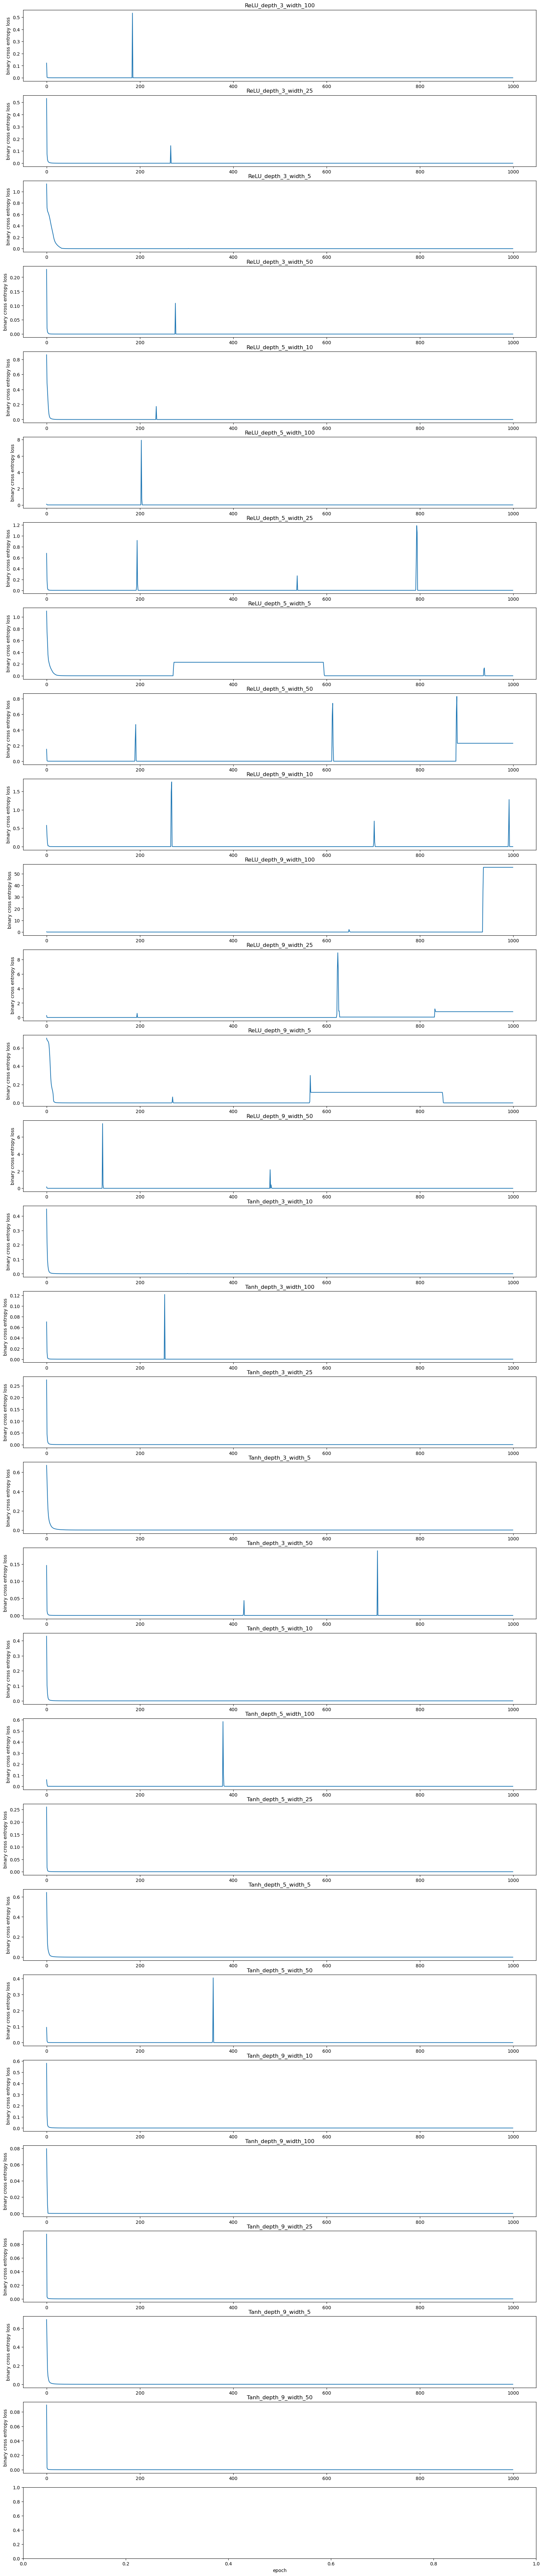

In [292]:
from glob import glob 
files = glob('./logs/*')
files = sorted(files)
logs = []
models_info = []
fig, ax = plt.subplots(len(files), figsize=(20,100))
for i,file in enumerate(files[1:]):
    with open(file, 'rb') as f:
        logs = pkl.load(f)
    model_name = file.split('/')[-1].split('.')[0]
    if model_name.split('_')[0]=='ReLU':
        final_test = test_losses[-1]
        width = int(model_name.split('_')[-1])
        depth = int(model_name.split('_')[2])
        models_info.append((width,depth,final_test))
    train_losses = logs['train_losses']
    test_losses = logs['test_losses']
    test_accs = logs['test_accs']
    print(f'for {model_name=}\n, final test loss: {test_losses[-1]}, \n\
                            final train: {train_losses[-1]} \n\
                                final test acc: {test_accs[-1]}')
    ax[i].plot(train_losses)
    ax[-1].set_xlabel('epoch')
    ax[i].set_ylabel('binary cross entropy loss')
    ax[i].set_title(model_name)
plt.savefig('/Users/mattlowery/Desktop/ml/hw/5/')





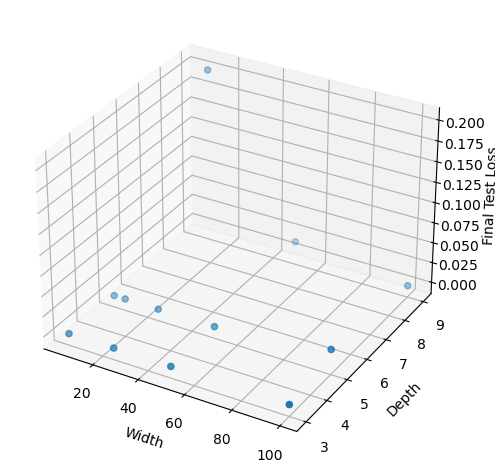

In [299]:
x = [info[0] for info in models_info]
y = [info[1] for info in models_info]
z = [info[2] for info in models_info]

# Set the threshold for outlier removal
threshold = 0.5

# Filter the data based on the threshold
filtered_x = [info[0] for info in models_info if info[2] < threshold]
filtered_y = [info[1] for info in models_info if info[2] < threshold]
filtered_z = [info[2] for info in models_info if info[2] < threshold]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(filtered_x, filtered_y, filtered_z)

ax.set_xlabel('Width')
ax.set_ylabel('Depth')
ax.set_zlabel('Final Test Loss')

plt.tight_layout()
plt.savefig('/Users/mattlowery/Desktop/ml/hw/5/3d')


In [295]:
z

[2.4376948749502135e-12,
 4.768488897883876e-10,
 2.0518045280369776e-13,
 6.918530104893463e-09,
 2.3858826557163663e-10,
 0.01645229363452229,
 3.685170530150154e-14,
 5.3346140609115846e-12,
 8.982245817364587e-07,
 0.20000000007869337,
 1.1475293688415582e-08,
 55.8,
 1.4000000000107886,
 0.014505507417395253]

z